In [2]:
# ===============================================
# MODEL NOTEBOOK – Velocity Motorsports Analytics
# Lap Time Prediction & Tyre/Weather Analysis
# ===============================================

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


In [3]:
df = pd.read_csv("data/final_f1_ml_laps_dataset.csv")

print("Shape:", df.shape)
df.head()


Shape: (23983, 48)


,season,gp_name,session_name,session_type,driver,team,lap_number,lap_time,sector_1_time,sector_2_time,sector_3_time,position,track_status,is_pit_lap,compound,stint,tyre_life,fresh_tyre,speed_mean,speed_max,throttle_mean,brake_mean,rpm_mean,rpm_max,drs_activations,air_temp,track_temp,humidity,wind_speed,wind_dir,pressure,speed_min,speed_std,speed_q1,speed_q3,speed_range,throttle_max,throttle_min,throttle_std,throttle_pct_full,brake_std,brake_pct_braking,rpm_std,gear_changes,gear_min,gear_max,drs_active_pct,drs_time_seconds
0,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,1,99.019,NaN,42.414,23.842,1,12,False,SOFT,1,4,False,185.071053,287,59.876316,0.202632,9993.065789,12317,380,27.3,31.2,22,0.6,190,1016.7,0.0,65.473737,137.0,236.00,287.0,100.0,0.0,43.095194,0.423684,0.402490,0.202632,1520.598745,52.0,1.0,7.0,1.0,99.381530
1,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,2,97.974,31.342,42.504,24.128,1,12,False,SOFT,1,5,False,195.407713,298,60.225895,0.203857,9773.179063,12063,363,27.3,31.1,22,0.0,208,1016.7,64.0,63.263189,145.5,242.50,234.0,100.0,0.0,43.626538,0.432507,0.403420,0.203857,1637.445568,43.0,2.0,8.0,1.0,97.750285
2,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,3,98.006,31.388,42.469,24.149,1,1,False,SOFT,1,6,False,198.095109,298,62.290761,0.184783,9756.970109,11795,0,27.3,31.2,22,0.6,170,1016.7,65.0,64.896809,147.0,253.00,233.0,100.0,0.0,43.299096,0.470109,0.388650,0.184783,1747.054894,36.0,3.0,8.0,0.0,0.000000
3,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,4,97.976,31.271,42.642,24.063,1,1,False,SOFT,1,7,False,195.786842,299,62.092105,0.200000,9723.621053,11960,0,27.2,31.1,22,0.8,236,1016.9,65.0,64.320556,143.5,245.75,234.0,100.0,0.0,43.281912,0.471053,0.400527,0.200000,1726.074671,39.0,3.0,8.0,0.0,0.000000
4,2023,Bahrain Grand Prix,Race,Race,VER,Red Bull Racing,5,98.035,31.244,42.724,24.067,1,1,False,SOFT,1,8,False,197.120879,301,60.884615,0.206044,9710.263736,11911,0,27.2,31.0,22,1.0,206,1016.7,65.0,64.729756,145.0,249.25,236.0,100.0,0.0,43.751400,0.450549,0.405019,0.206044,1732.516039,36.0,3.0,8.0,0.0,0.000000


In [4]:
# Remove invalid / nonsense laps (e.g., 0s)
df = df[df["lap_time"] > 1.0].copy()

# Drop rows with no sector times (usually outlaps / inlaps / incomplete)
df = df.dropna(subset=["sector_1_time", "sector_2_time", "sector_3_time"])

print("After basic cleaning:", df.shape)

# Quick NA check
na_counts = df.isna().sum().sort_values(ascending=False)
print("Missing values per column (top 20):")
print(na_counts.head(20))


After basic cleaning: (23553, 48)
Missing values per column (top 20):
season               0
gp_name              0
track_temp           0
humidity             0
wind_speed           0
wind_dir             0
pressure             0
speed_min            0
speed_std            0
speed_q1             0
speed_q3             0
speed_range          0
throttle_max         0
throttle_min         0
throttle_std         0
throttle_pct_full    0
brake_std            0
brake_pct_braking    0
rpm_std              0
gear_changes         0
dtype: int64


In [5]:
# Metadata (not used directly as features, but useful for slicing)
meta_cols = [
    "season", "gp_name", "session_name", "driver", "team"
]

target_col = "lap_time"

# Lap / race context
lap_features = [
    "lap_number",
    "sector_1_time", "sector_2_time", "sector_3_time",
    "position",
    "track_status",
    "is_pit_lap"
]

# Tyre-related – core for engineering questions
tyre_features = [
    "compound",
    "stint",
    "tyre_life",
    "fresh_tyre",
]

# Weather – proxies for tyre behaviour & grip
weather_features = [
    "air_temp",
    "track_temp",
    "humidity",
    "wind_speed",
    "wind_dir",
    "pressure"
]

# Basic telemetry from phase 1
telemetry_basic = [
    "speed_mean",
    "speed_max",
    "throttle_mean",
    "brake_mean",
    "rpm_mean",
    "rpm_max",
    "drs_activations"
]

# BONUS telemetry features from phase 2
bonus_features = [
    "speed_min", "speed_std", "speed_q1", "speed_q3", "speed_range",
    "throttle_std", "throttle_pct_full",
    "brake_std", "brake_pct_braking",
    "rpm_std",
    "gear_changes", "gear_min",
    "drs_active_pct", "drs_time_seconds"
]

# Low-value / diagnostic only – kept in df but not used here
diagnostic_features = [
    # keep them in df but not in model
    "throttle_max", "throttle_min",
    "gear_max",  # usually same across laps
    "brake_max", "brake_min"
]

# Full feature list for main lap time model (Option A)
categorical_features = ["driver", "team", "compound"]  # from meta + tyre

numeric_features = (
    [f for f in lap_features if f not in ["is_pit_lap"]] +
    weather_features +
    telemetry_basic +
    bonus_features +
    ["stint", "tyre_life", "fresh_tyre", "track_status", "is_pit_lap"]
)

# Deduplicate & keep only columns that actually exist
numeric_features = sorted(list({c for c in numeric_features if c in df.columns}))
print("Categorical features:", categorical_features)
print("Numeric features ({}):".format(len(numeric_features)), numeric_features)


Categorical features: ['driver', 'team', 'compound']
Numeric features (37): ['air_temp', 'brake_mean', 'brake_pct_braking', 'brake_std', 'drs_activations', 'drs_active_pct', 'drs_time_seconds', 'fresh_tyre', 'gear_changes', 'gear_min', 'humidity', 'is_pit_lap', 'lap_number', 'position', 'pressure', 'rpm_max', 'rpm_mean', 'rpm_std', 'sector_1_time', 'sector_2_time', 'sector_3_time', 'speed_max', 'speed_mean', 'speed_min', 'speed_q1', 'speed_q3', 'speed_range', 'speed_std', 'stint', 'throttle_mean', 'throttle_pct_full', 'throttle_std', 'track_status', 'track_temp', 'tyre_life', 'wind_dir', 'wind_speed']


In [6]:
# Ensure we have no target NaNs
df_model = df.dropna(subset=[target_col]).copy()

X = df_model[categorical_features + numeric_features]
y = df_model[target_col]

print("Final modeling dataset shape:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Final modeling dataset shape: (23553, 40)
Train size: (20020, 40) Test size: (3533, 40)


In [7]:
from sklearn.impute import SimpleImputer

# Preprocessing for numeric features: impute (if needed) + scale
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Preprocessing for categorical features: impute + one-hot
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Baseline model: Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

# Main model: LightGBM – good for tabular data
lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(
    steps=[("pre", preprocessor), ("model", rf_model)]
)

lgbm_pipeline = Pipeline(
    steps=[("pre", preprocessor), ("model", lgbm_model)]
)

print("Pipelines ready.")


Pipelines ready.


In [8]:
def eval_model(name, pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f"\n==== {name} ====")
    print(f"MAE : {mae:.3f} sec")
    print(f"RMSE: {rmse:.3f} sec")
    print(f"R²  : {r2:.3f}")

    return {
        "name": name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "pipeline": pipeline,
        "y_pred": y_pred
    }

rf_results = eval_model("RandomForest", rf_pipeline, X_train, X_test, y_train, y_test)
lgbm_results = eval_model("LightGBM", lgbm_pipeline, X_train, X_test, y_train, y_test)


c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



==== RandomForest ====
MAE : 0.195 sec
RMSE: 0.827 sec
R²  : 0.996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 20020, number of used features: 74
[LightGBM] [Info] Start training from score 91.106446

==== LightGBM ====
MAE : 0.282 sec
RMSE: 0.706 sec
R²  : 0.997


c:\Users\shrey\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Using LightGBM as primary model.


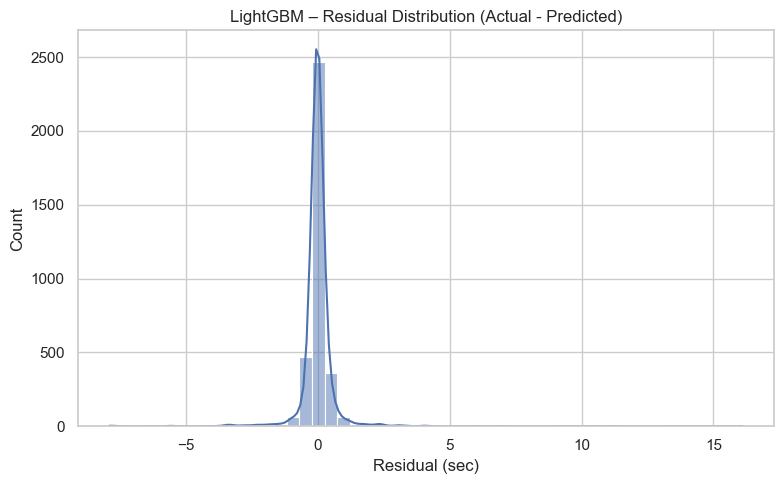

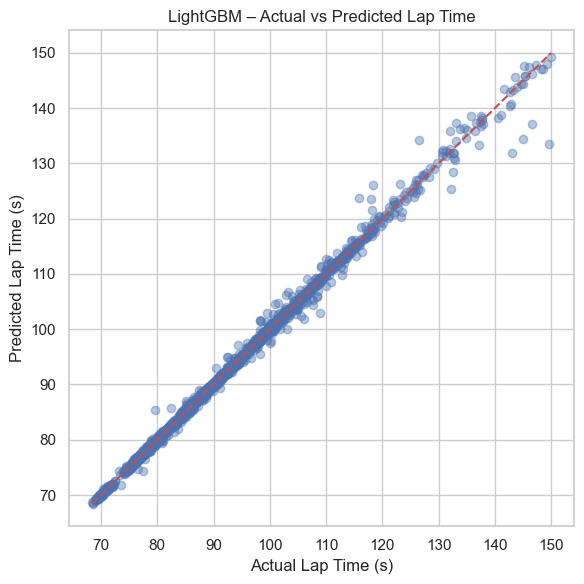

In [9]:
# Choose the better model by RMSE (or R²)
best_results = lgbm_results if lgbm_results["rmse"] <= rf_results["rmse"] else rf_results
best_name = best_results["name"]
best_pipeline = best_results["pipeline"]
best_pred = best_results["y_pred"]

print(f"\nUsing {best_name} as primary model.")

# Residuals
residuals = y_test - best_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title(f"{best_name} – Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual (sec)")
plt.tight_layout()
plt.show()

# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title(f"{best_name} – Actual vs Predicted Lap Time")
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6402
[LightGBM] [Info] Number of data points in the train set: 20020, number of used features: 74
[LightGBM] [Info] Start training from score 91.106446
Top 25 features:


,feature,importance
18,num__sector_1_time,2034
20,num__sector_3_time,2004
19,num__sector_2_time,1832
24,num__speed_q1,777
8,num__gear_changes,583
22,num__speed_mean,493
4,num__drs_activations,417
25,num__speed_q3,399
27,num__speed_std,392
29,num__throttle_mean,356


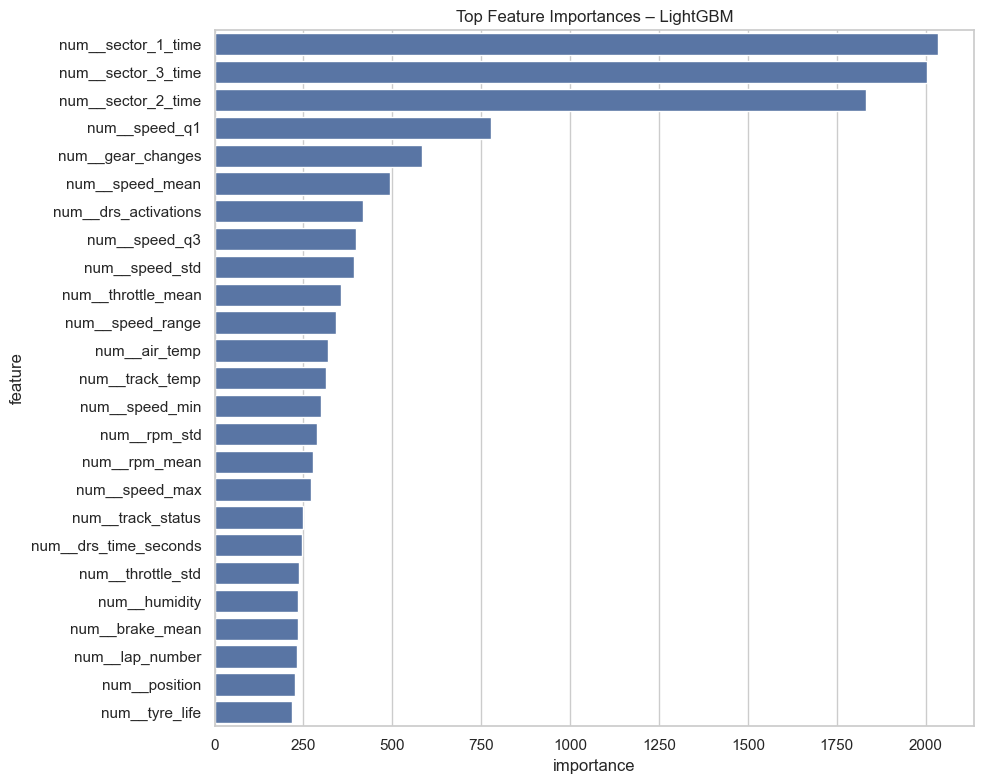

In [10]:
# We'll use the LightGBM pipeline for interpretability
final_pipeline = lgbm_pipeline
final_pipeline.fit(X_train, y_train)

# Access fitted transformers & model
pre = final_pipeline.named_steps["pre"]
model = final_pipeline.named_steps["model"]

feature_names = pre.get_feature_names_out()
importances = model.feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("Top 25 features:")
display(imp_df.head(25))

plt.figure(figsize=(10,8))
top_n = 25
sns.barplot(
    data=imp_df.head(top_n),
    x="importance",
    y="feature",
    orient="h"
)
plt.title("Top Feature Importances – LightGBM")
plt.tight_layout()
plt.show()


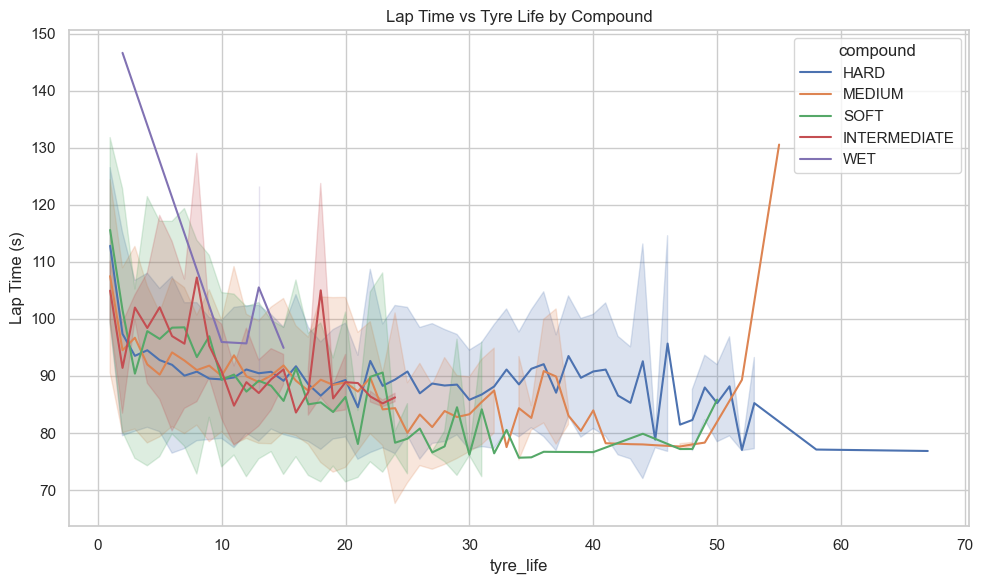

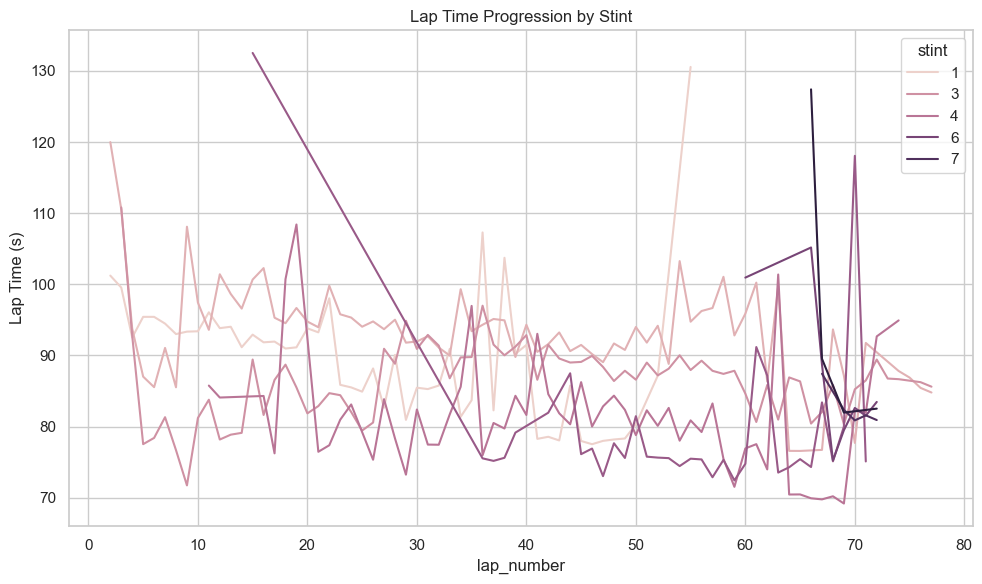

In [11]:
# Helper: add predicted lap times to original df for inspection
df_eval = df_model.loc[y_test.index].copy()
df_eval["pred_lap_time"] = best_pred
df_eval["error"] = df_eval["lap_time"] - df_eval["pred_lap_time"]

# Lap time vs tyre age by compound
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_eval,
    x="tyre_life",
    y="lap_time",
    hue="compound",
    errorbar="sd"
)
plt.title("Lap Time vs Tyre Life by Compound")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()

# Degradation per stint
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_eval,
    x="lap_number",
    y="lap_time",
    hue="stint",
    errorbar=None
)
plt.title("Lap Time Progression by Stint")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()


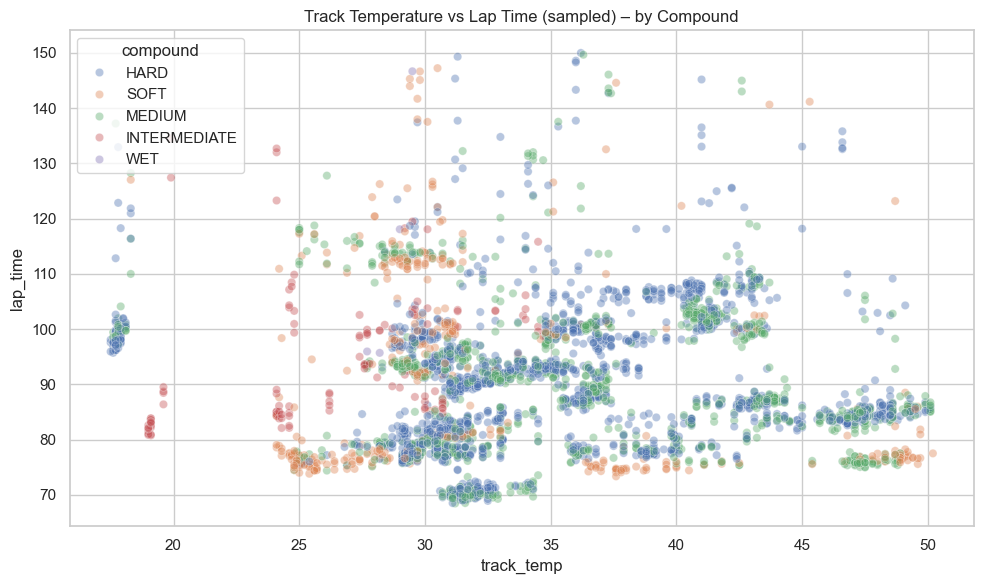

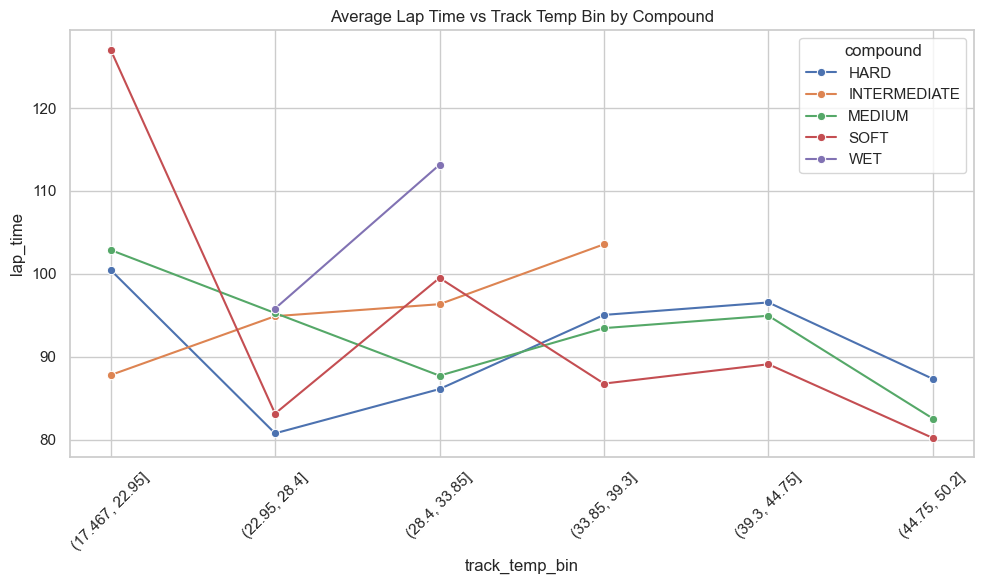

In [13]:
# Track temp vs lap time, colored by compound
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_eval.sample(min(len(df_eval), 5000), random_state=42),
    x="track_temp",
    y="lap_time",
    hue="compound",
    alpha=0.4
)
plt.title("Track Temperature vs Lap Time (sampled) – by Compound")
plt.tight_layout()
plt.show()

# Binned analysis: average lap time by track temp bin & compound
df_eval["track_temp_bin"] = pd.cut(df_eval["track_temp"], bins=6).astype(str)

temp_summary = (
    df_eval.groupby(["track_temp_bin", "compound"])["lap_time"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=temp_summary,
    x="track_temp_bin",
    y="lap_time",
    hue="compound",
    marker="o"
)
plt.xticks(rotation=45)
plt.title("Average Lap Time vs Track Temp Bin by Compound")
plt.tight_layout()
plt.show()


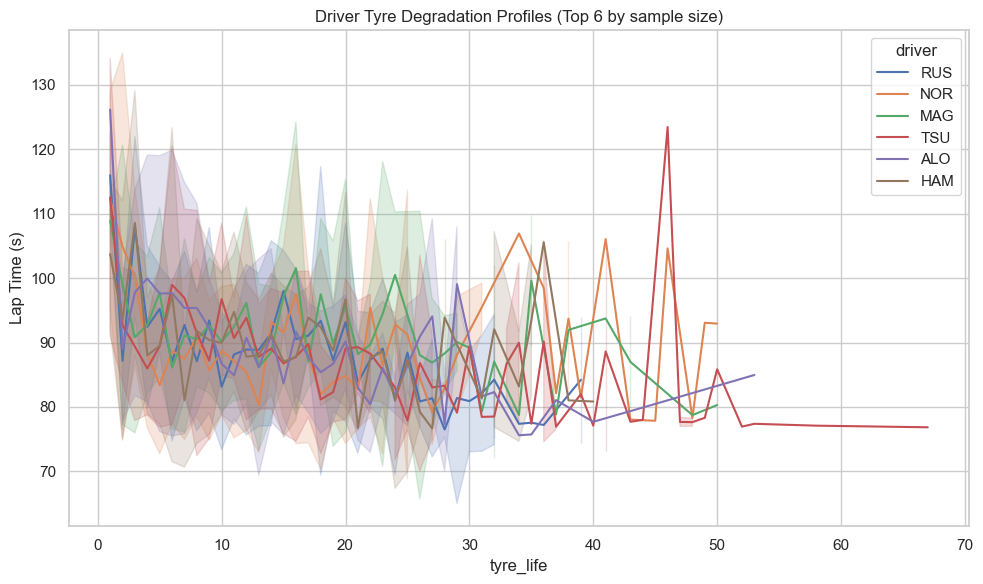

Driver model residuals (negative = model predicts slower than actual):


,mean,std,count
driver,,,
HUL,-0.126333,0.906837,167
HAM,-0.095788,0.470477,181
SAR,-0.062504,1.523026,175
STR,-0.047809,0.492910,178
RUS,-0.042343,0.808085,191
ZHO,-0.017256,0.614825,171
ALB,-0.015330,0.380639,166
NOR,-0.005205,0.369504,182
VER,0.004878,0.474215,178


In [14]:
# Average lap time vs tyre_life per driver (top 6 drivers by sample count)
driver_counts = df_eval["driver"].value_counts()
top_drivers = driver_counts.head(6).index.tolist()

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_eval[df_eval["driver"].isin(top_drivers)],
    x="tyre_life",
    y="lap_time",
    hue="driver",
    errorbar="sd"
)
plt.title("Driver Tyre Degradation Profiles (Top 6 by sample size)")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()

# Table: driver mean error (actual - predicted)
driver_error = (
    df_eval.groupby("driver")["error"]
    .agg(["mean", "std", "count"])
    .sort_values("mean")
)
print("Driver model residuals (negative = model predicts slower than actual):")
display(driver_error.head(10))


In [20]:
# This cell is optional – requires shap to be installed.
try:
    import shap

    # Use a small sample for speed
    X_sample = X_train.sample(min(len(X_train), 5000), random_state=42)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(pre.transform(X_sample))

    shap.summary_plot(
        shap_values,
        features=pre.transform(X_sample),
        feature_names=feature_names,
        plot_type="bar",
        max_display=20
    )

except ImportError:
    print("shap is not installed. Run `pip install shap` to enable SHAP analysis.")


shap is not installed. Run `pip install shap` to enable SHAP analysis.
